In [65]:
import os
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Reshape

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)
# values were colected every 10 minutes
# slice [start:stop:step], starting from index 5 take every 6th record to subsample every hour
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
dataset = df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].astype(float)
dataset.head()

,T (degC),p (mbar),rho (g/m**3)
5,-8.05,996.50,1307.86
11,-8.88,996.62,1312.25
17,-8.81,996.84,1312.18
23,-9.05,996.99,1313.61
29,-9.63,997.46,1317.19


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

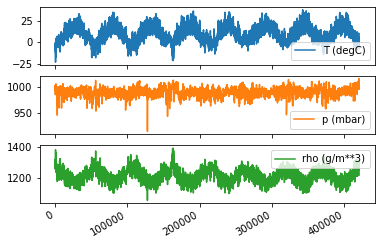

In [6]:
dataset.plot(subplots=True)

In [7]:
# multi variables
cols = list(dataset)
cols

['T (degC)', 'p (mbar)', 'rho (g/m**3)']

In [8]:
# Preprocessing + reshape dataset  (time, var, values, channel=1)
scaler =  MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset.values.reshape(-1, len(cols)))

In [9]:
display(pd.DataFrame(scaled_data, columns = cols).head())

,T (degC),p (mbar),rho (g/m**3)
0,0.245003,0.815223,0.743542
1,0.231179,0.816403,0.756682
2,0.232345,0.818566,0.756473
3,0.228348,0.820041,0.760753
4,0.218688,0.824663,0.771469


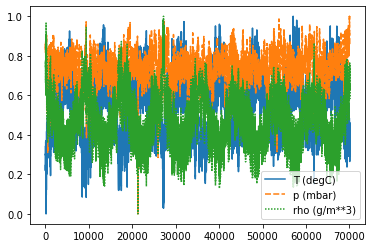

In [10]:
sns.lineplot(data=pd.DataFrame(scaled_data))
plt.legend(labels=cols)

In [12]:
scaled_data.shape

(70091, 3)

In [13]:
# Split train/test data
train_dataset, test_dataset = np.vsplit(scaled_data, [int(len(dataset)*0.8)])


In [14]:
train_dataset.shape, test_dataset.shape

((56072, 3), (14019, 3))

In [15]:
display(pd.DataFrame(train_dataset, columns = cols).head())


,T (degC),p (mbar),rho (g/m**3)
0,0.245003,0.815223,0.743542
1,0.231179,0.816403,0.756682
2,0.232345,0.818566,0.756473
3,0.228348,0.820041,0.760753
4,0.218688,0.824663,0.771469


In [70]:
x_train = []
y_train = []

# use 7 days for prediction = 1h*24*7 = 168, predict next day = 1h*24 = 24
n_future = 24
n_past = 168

for i in range(n_past, len(train_dataset)- n_future+1):
    if i+n_future > len(train_dataset)- n_future+1 :
        break
    x_train.append(train_dataset[i-n_past:i, 0:train_dataset.shape[1]])
    y_train.append(train_dataset[i+n_future-1:i+n_future, 0:train_dataset.shape[1]])

In [71]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [72]:
x_train.shape, y_train.shape 

((55858, 168, 3), (55858, 1, 3))

In [73]:
display(pd.DataFrame(x_train[1], columns = cols))

,T (degC),p (mbar),rho (g/m**3)
0,0.231179,0.816403,0.756682
1,0.232345,0.818566,0.756473
2,0.228348,0.820041,0.760753
3,0.218688,0.824663,0.771469
4,0.218021,0.827122,0.773025
...,...,...,...
163,0.238508,0.811191,0.748002
164,0.222352,0.821221,0.766680
165,0.201199,0.828793,0.789248
166,0.199534,0.835185,0.793409


In [74]:
display(pd.DataFrame(y_train[1], columns = cols))

,T (degC),p (mbar),rho (g/m**3)
0,0.138241,0.882683,0.870274


In [75]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))

model.add(Dense(n_future*y_train.shape[2]))
model.add(Reshape([n_future, y_train.shape[2]]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 168, 50)           10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 168, 50)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 168, 50)           20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 168, 50)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_3 (Dense)              (None, 72)                1512      
_________________________________________________________________
reshape_3 (Reshape)          (None, 24, 3)            

In [76]:
history = model.fit(x_train, y_train, epochs =30, batch_size=32,
                    validation_split=0.20, verbose=1, shuffle = False)

Epoch 1/30
1397/1397 [==============================] - 328s 230ms/step - loss: 0.0130 - val_loss: 0.0226
Epoch 2/30
1397/1397 [==============================] - 319s 228ms/step - loss: 0.0081 - val_loss: 0.0221
Epoch 3/30
1397/1397 [==============================] - 317s 227ms/step - loss: 0.0076 - val_loss: 0.0189
Epoch 4/30
1397/1397 [==============================] - 318s 228ms/step - loss: 0.0055 - val_loss: 0.0156
Epoch 5/30
1397/1397 [==============================] - 319s 228ms/step - loss: 0.0050 - val_loss: 0.0150
Epoch 6/30
1397/1397 [==============================] - 319s 229ms/step - loss: 0.0047 - val_loss: 0.0145
Epoch 7/30
1397/1397 [==============================] - 320s 229ms/step - loss: 0.0046 - val_loss: 0.0137
Epoch 8/30
1397/1397 [==============================] - 324s 232ms/step - loss: 0.0044 - val_loss: 0.0122
Epoch 9/30
1397/1397 [==============================] - 320s 229ms/step - loss: 0.0041 - val_loss: 0.0100
Epoch 10/30
1397/1397 [=======================

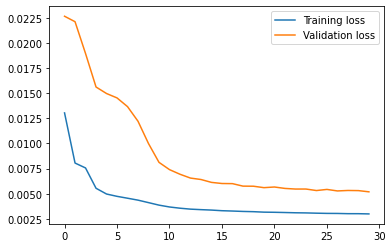

In [77]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [78]:
# forecast
x_test = []
y_test = []

for i in range(n_past, len(test_dataset)- n_future+1):
    if i+n_future > len(test_dataset)- n_future+1 :
        break
    x_test.append(test_dataset[i-n_past:i, 0:test_dataset.shape[1]])
    y_test.append(test_dataset[i+n_future-1:i+n_future, 0:test_dataset.shape[1]])

x_test, y_test = np.array(x_test), np.array(y_test)    
x_test.shape

(13805, 168, 3)

In [79]:
forecast = model.predict(x_test)

In [80]:
forecast.shape

(13805, 24, 3)

In [81]:
forecast = np.reshape(forecast, (-1, forecast.shape[2]))
forecast.shape

(331320, 3)

In [82]:
predicted = scaler.inverse_transform(forecast)

In [83]:
predicted.shape

(331320, 3)

In [84]:
train_unscaled = scaler.inverse_transform(y_train.reshape(-1, y_train.shape[2]))
test_unscaled = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2]))

In [85]:
train_unscaled.shape, test_unscaled.shape

((55858, 3), (13805, 3))

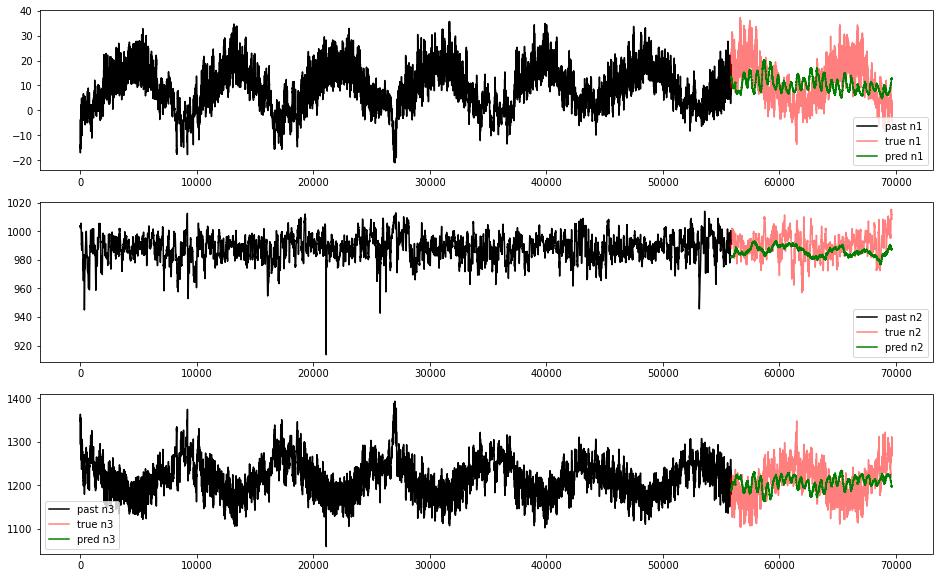

In [89]:
# Check Predictions

a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train)+len(y_test))

plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(a_axis, train_unscaled[:,0], color = 'black', label ='past n1')
plt.plot(b_axis, test_unscaled[:,0], color = 'red', alpha=0.5, label ='true n1')
plt.plot(b_axis, predicted[:len(y_test),0], color = 'green', label ='pred n1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(a_axis, train_unscaled[:,1], color = 'black', label ='past n2')
plt.plot(b_axis, test_unscaled[:,1], color = 'red', alpha=0.5, label ='true n2')
plt.plot(b_axis, predicted[:len(y_test),1], color = 'green', label ='pred n2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(a_axis, train_unscaled[:,2], color = 'black', label ='past n3')
plt.plot(b_axis, test_unscaled[:,2], color = 'red', alpha=0.5, label ='true n3')
plt.plot(b_axis, predicted[:len(y_test),2], color = 'green', label ='pred n3')
plt.legend()

'''
plt.subplot(2,2,4)
plt.plot(a_axis, train_unscaled[:,3], color = 'black', label ='past n4')
plt.plot(b_axis, test_unscaled[:,3], color = 'red', alpha=0.5, label ='true n4')
plt.plot(b_axis, predicted[:,3], color = 'green', label ='pred n4')
plt.legend()
'''

plt.show()

In [91]:
import math

testScore = math.sqrt(mean_squared_error(test_unscaled[:24,0], predicted[:24,0]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 4.84 RMSE
